In [2]:
import os
import xml.etree.ElementTree as ET
from PIL import Image, UnidentifiedImageError
import glob
import json

# Define dataset root
dataset_dir = r"C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD"

# Class mapping — update this as needed
class_map = {
    'car': 0,
    'truck': 1,
    'bus': 2,
    'autorickshaw': 3,
    'motorcycle': 4,
    'bicycle': 5,
    'mini-bus': 6,
    'scooter': 4
}

# Convert XML to JSON
def xml_to_json(xml_path, image_path, json_path):
    try:
        img = Image.open(image_path)
        img_width, img_height = img.size
    except UnidentifiedImageError:
        print(f"⚠️ Unreadable image: {image_path}. Skipping.")
        return
    except FileNotFoundError:
        print(f"⚠️ Image not found: {image_path}. Skipping.")
        return

    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
    except Exception as e:
        print(f"❌ Error reading {xml_path}: {e}")
        return

    boxes = []
    labels = []

    for obj in root.findall('object'):
        raw_class_name = obj.find('name').text.strip().lower()
        base_class_name = raw_class_name.split('_')[0]

        if base_class_name not in class_map:
            print(f"⏭️ Skipping unknown class '{raw_class_name}' (base: '{base_class_name}') in {xml_path}")
            continue

        class_id = class_map[base_class_name]
        bbox = obj.find('bndbox')

        try:
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
        except Exception as e:
            print(f"⚠️ Invalid bbox in {xml_path}: {e}")
            continue

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(class_id)

    if boxes:
        with open(json_path, 'w') as f:
            json.dump({"boxes": boxes, "labels": labels}, f)
    else:
        print(f"🚫 No valid objects in {xml_path}, JSON file not written.")

# Process splits
for split in ['train', 'val', 'test']:
    image_dir = os.path.join(dataset_dir, split, 'images')
    anno_dir = os.path.join(dataset_dir, split, 'annos')
    label_dir = os.path.join(dataset_dir, split, 'frcnnlabels')  # Still using this folder for JSONs

    os.makedirs(label_dir, exist_ok=True)

    for image_filename in os.listdir(image_dir):
        if image_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(image_dir, image_filename)
            xml_filename = os.path.splitext(image_filename)[0] + '.xml'
            xml_path = os.path.join(anno_dir, xml_filename)

            if os.path.exists(xml_path):
                json_filename = os.path.splitext(image_filename)[0] + '.json'
                json_path = os.path.join(label_dir, json_filename)
                xml_to_json(xml_path, image_path, json_path)
            else:
                print(f"❌ Missing XML annotation: {xml_filename}")

# Optional: Remove all empty .json files (if created)
for split in ['train', 'val', 'test']:
    label_dir = os.path.join(dataset_dir, split, 'frcnnlabels')
    for json_file in glob.glob(os.path.join(label_dir, '*.json')):
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                if not data["boxes"]:
                    os.remove(json_file)
                    print(f"🗑️ Removed empty file: {json_file}")
        except Exception:
            os.remove(json_file)
            print(f"🗑️ Removed corrupt file: {json_file}")

print("✅ All XML files converted to JSON without normalization.")


✅ All XML files converted to JSON without normalization.


In [3]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [4]:
# Load the pre-trained Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Number of classes (your dataset classes + 1 for background)
num_classes = 8  # For example, 2 classes + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the head of the model with a new one (for the number of classes in your dataset)
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

c:\Users\cl502_09\.conda\envs\torch-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\cl502_09\.conda\envs\torch-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


First image shape: torch.Size([3, 1080, 1920])
First image bounding boxes: tensor([[ 666.,  563.,  843.,  704.],
        [ 825.,  573., 1296.,  938.],
        [1286.,  628., 1920., 1080.]])
First image path: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\images\623.jpg


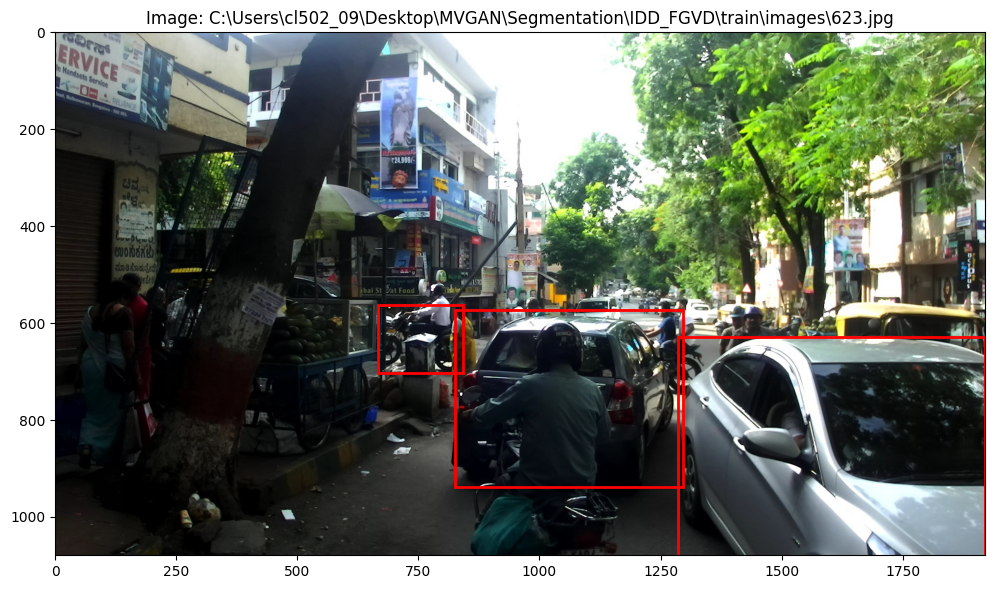

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.utils.data import Dataset
import os
from PIL import Image
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class FGVDataset(Dataset):
    def __init__(self, data_root, split='train', transforms=None):
        self.data_root = data_root
        self.split = split
        self.transforms = transforms
        
        self.img_dir = os.path.join(self.data_root, self.split, 'images')
        self.lbl_dir = os.path.join(self.data_root, self.split, 'frcnnlabels')
        
        self.image_files = [f for f in os.listdir(self.img_dir) if f.endswith('.jpg')]

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        # Correct annotation file path
        annotation_file = img_name.replace('.jpg', '.json')  # assuming annotations are in .json format
        annotation_path = os.path.join(self.lbl_dir, annotation_file)  # Ensure the path is correct

        boxes = []
        labels = []

        try:
            # Check if the annotation file exists
            if os.path.exists(annotation_path):
                with open(annotation_path, 'r') as f:
                    data = json.load(f)
                    boxes = data.get("boxes", [])
                    labels = data.get("labels", [])

                    # Ensure boxes are in the correct format
                    boxes = [[float(x) for x in box] for box in boxes]
                    labels = [int(label) for label in labels]

                    # Validate boxes (skip invalid boxes)
                    valid_boxes = []
                    valid_labels = []
                    for i, box in enumerate(boxes):
                        xmin, ymin, xmax, ymax = box
                        if (xmax - xmin) > 0 and (ymax - ymin) > 0:
                            valid_boxes.append(box)
                            valid_labels.append(labels[i])

                    boxes = valid_boxes
                    labels = valid_labels

            else:
                print(f"Annotation file not found for {img_name}. Using dummy values.")
        except Exception as e:
            print(f"Error reading {annotation_file}: {e}")

        # If no valid boxes, use dummy box
        if len(boxes) == 0:
            boxes = torch.tensor([[0.0, 0.0, 1.0, 1.0]], dtype=torch.float32)
            labels = torch.tensor([0], dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        
        if self.transforms:
            img = self.transforms(img)

        return img, target, img_path

    def __len__(self):
        return len(self.image_files)


# Define transformations (remove resizing here)
transform = T.Compose([
    T.ToTensor(),  # Convert to tensor
])

# Root path to dataset
data_root = r'C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD'

# Datasets
train_dataset = FGVDataset(data_root=data_root, split='train', transforms=transform)
val_dataset = FGVDataset(data_root=data_root, split='val', transforms=transform)
test_dataset = FGVDataset(data_root=data_root, split='test', transforms=transform)

# Data loaders
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Function to visualize an image and its bounding boxes
def visualize_image_with_labels(image, target, image_path):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    # Draw bounding boxes
    boxes = target['boxes']
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"Image: {image_path}")
    plt.show()

# Example usage: Visualize one image from the train loader
for images, targets, image_paths in train_loader:
    print(f"First image shape: {images[0].shape}")
    print(f"First image bounding boxes: {targets[0]['boxes']}")
    print(f"First image path: {image_paths[0]}")
    
    # Visualize the first image with its bounding boxes
    image_to_visualize = images[0].permute(1, 2, 0).numpy()  # Convert to HWC format for plt.imshow
    image_to_visualize = (image_to_visualize * 255).astype('uint8')  # Convert to [0, 255] range for display
    visualize_image_with_labels(image_to_visualize, targets[0], image_paths[0])

    break  # Just show the first image


In [10]:
import os
import torch
from tqdm import tqdm

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f"✅ Using device: {device}")

# Optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Constants
MIN_BOX_SIZE = 1e-4
LABELS_ROOT = r'C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD'

def load_target_from_json(image_path):
    img_dir, split = os.path.split(os.path.dirname(image_path))
    json_name = os.path.splitext(os.path.basename(image_path))[0] + ".json"
    label_path = os.path.join(LABELS_ROOT, "train", "frcnnlabels", json_name)

    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Annotation file not found: {label_path}")
    
    with open(label_path, 'r') as f:
        data = json.load(f)

    boxes = torch.tensor(data["boxes"], dtype=torch.float32)
    labels = torch.tensor(data["labels"], dtype=torch.int64)
    return {"boxes": boxes, "labels": labels}

# Training loop (no evaluation metrics here)
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    skipped_images = 0
    print(f"\n🔁 Epoch {epoch + 1}/{num_epochs}")

    for images_batch, targets_batch, paths_batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}", leave=False):
        images = []
        targets = []

        for img, _, path in zip(images_batch, targets_batch, paths_batch):
            try:
                target = load_target_from_json(path)
            except FileNotFoundError as e:
                print(f"⚠️ Error loading label: {e}")
                skipped_images += 1
                continue
            except Exception as e:
                print(f"⚠️ Error processing {path}: {e}")
                skipped_images += 1
                continue

            boxes = target["boxes"]
            labels = target["labels"]

            valid_boxes = []
            valid_labels = []

            for i, box in enumerate(boxes):
                xmin, ymin, xmax, ymax = box
                if (xmax - xmin) > MIN_BOX_SIZE and (ymax - ymin) > MIN_BOX_SIZE:
                    valid_boxes.append(box)
                    valid_labels.append(labels[i])

            if not valid_boxes:
                print(f"⚠️ Skipping image with no valid boxes: {path}")
                skipped_images += 1
                continue

            images.append(img.to(device))
            targets.append({
                "boxes": torch.stack(valid_boxes).to(device),
                "labels": torch.tensor(valid_labels).to(device)
            })

        if not images or not targets:
            continue

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        if torch.isnan(losses):
            print("🚨 NaN loss detected. Skipping batch.")
            continue

        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        train_loss += losses.item()

    lr_scheduler.step()
    avg_loss = train_loss / len(train_loader)
    print(f"📉 Epoch [{epoch + 1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")
    print(f"🚫 Skipped images: {skipped_images}")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")
        print(f"💾 Checkpoint saved for epoch {epoch + 1}")

print("✅ Training complete!")


✅ Using device: cuda

🔁 Epoch 1/50


📉 Epoch [1/50] - Avg Loss: 0.1391
🚫 Skipped images: 0

🔁 Epoch 2/50


📉 Epoch [2/50] - Avg Loss: 0.1318
🚫 Skipped images: 0

🔁 Epoch 3/50


📉 Epoch [3/50] - Avg Loss: 0.1224
🚫 Skipped images: 0

🔁 Epoch 4/50


📉 Epoch [4/50] - Avg Loss: 0.0889
🚫 Skipped images: 0

🔁 Epoch 5/50


📉 Epoch [5/50] - Avg Loss: 0.0792
🚫 Skipped images: 0

🔁 Epoch 6/50


📉 Epoch [6/50] - Avg Loss: 0.0740
🚫 Skipped images: 0

🔁 Epoch 7/50


📉 Epoch [7/50] - Avg Loss: 0.0687
🚫 Skipped images: 0

🔁 Epoch 8/50


📉 Epoch [8/50] - Avg Loss: 0.0680
🚫 Skipped images: 0

🔁 Epoch 9/50


📉 Epoch [9/50] - Avg Loss: 0.0679
🚫 Skipped images: 0

🔁 Epoch 10/50


📉 Epoch [10/50] - Avg Loss: 0.0672
🚫 Skipped images: 0
💾 Checkpoint saved for epoch 10

🔁 Epoch 11/50


📉 Epoch [11/50] - Avg Loss: 0.0674
🚫 Skipped images: 0

🔁 Epoch 12/50


📉 Epoch [12/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 13/50


📉 Epoch [13/50] - Avg Loss: 0.0672
🚫 Skipped images: 0

🔁 Epoch 14/50


📉 Epoch [14/50] - Avg Loss: 0.0669
🚫 Skipped images: 0

🔁 Epoch 15/50


📉 Epoch [15/50] - Avg Loss: 0.0672
🚫 Skipped images: 0

🔁 Epoch 16/50


📉 Epoch [16/50] - Avg Loss: 0.0670
🚫 Skipped images: 0

🔁 Epoch 17/50


📉 Epoch [17/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 18/50


📉 Epoch [18/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 19/50


📉 Epoch [19/50] - Avg Loss: 0.0668
🚫 Skipped images: 0

🔁 Epoch 20/50


📉 Epoch [20/50] - Avg Loss: 0.0671
🚫 Skipped images: 0
💾 Checkpoint saved for epoch 20

🔁 Epoch 21/50


📉 Epoch [21/50] - Avg Loss: 0.0672
🚫 Skipped images: 0

🔁 Epoch 22/50


📉 Epoch [22/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 23/50


📉 Epoch [23/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 24/50


📉 Epoch [24/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 25/50


📉 Epoch [25/50] - Avg Loss: 0.0672
🚫 Skipped images: 0

🔁 Epoch 26/50


📉 Epoch [26/50] - Avg Loss: 0.0670
🚫 Skipped images: 0

🔁 Epoch 27/50


📉 Epoch [27/50] - Avg Loss: 0.0670
🚫 Skipped images: 0

🔁 Epoch 28/50


📉 Epoch [28/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 29/50


📉 Epoch [29/50] - Avg Loss: 0.0669
🚫 Skipped images: 0

🔁 Epoch 30/50


📉 Epoch [30/50] - Avg Loss: 0.0672
🚫 Skipped images: 0
💾 Checkpoint saved for epoch 30

🔁 Epoch 31/50


📉 Epoch [31/50] - Avg Loss: 0.0669
🚫 Skipped images: 0

🔁 Epoch 32/50


📉 Epoch [32/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 33/50


📉 Epoch [33/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 34/50


📉 Epoch [34/50] - Avg Loss: 0.0670
🚫 Skipped images: 0

🔁 Epoch 35/50


📉 Epoch [35/50] - Avg Loss: 0.0668
🚫 Skipped images: 0

🔁 Epoch 36/50


📉 Epoch [36/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 37/50


📉 Epoch [37/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 38/50


📉 Epoch [38/50] - Avg Loss: 0.0670
🚫 Skipped images: 0

🔁 Epoch 39/50


📉 Epoch [39/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 40/50


📉 Epoch [40/50] - Avg Loss: 0.0668
🚫 Skipped images: 0
💾 Checkpoint saved for epoch 40

🔁 Epoch 41/50


📉 Epoch [41/50] - Avg Loss: 0.0670
🚫 Skipped images: 0

🔁 Epoch 42/50


📉 Epoch [42/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 43/50


📉 Epoch [43/50] - Avg Loss: 0.0670
🚫 Skipped images: 0

🔁 Epoch 44/50


📉 Epoch [44/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 45/50


📉 Epoch [45/50] - Avg Loss: 0.0669
🚫 Skipped images: 0

🔁 Epoch 46/50


📉 Epoch [46/50] - Avg Loss: 0.0671
🚫 Skipped images: 0

🔁 Epoch 47/50


📉 Epoch [47/50] - Avg Loss: 0.0669
🚫 Skipped images: 0

🔁 Epoch 48/50


📉 Epoch [48/50] - Avg Loss: 0.0669
🚫 Skipped images: 0

🔁 Epoch 49/50


📉 Epoch [49/50] - Avg Loss: 0.0668
🚫 Skipped images: 0

🔁 Epoch 50/50


📉 Epoch [50/50] - Avg Loss: 0.0670
🚫 Skipped images: 0
💾 Checkpoint saved for epoch 50
✅ Training complete!


#### Eval Metrics

In [11]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, r2_score

def box_centers(boxes):
    return [( (x1 + x2) / 2, (y1 + y2) / 2 ) for x1, y1, x2, y2 in boxes]

def calculate_metrics(pred_boxes, pred_labels, true_boxes, true_labels):
    total_precision = []
    total_recall = []

    for pred_l, true_l in zip(pred_labels, true_labels):
        if len(pred_l) == 0 and len(true_l) == 0:
            continue
        elif len(pred_l) == 0:
            total_precision.append(1.0)
            total_recall.append(0.0)
        elif len(true_l) == 0:
            total_precision.append(0.0)
            total_recall.append(1.0)
        else:
            min_len = min(len(pred_l), len(true_l))
            total_precision.append(precision_score(true_l[:min_len], pred_l[:min_len], average='macro', zero_division=1))
            total_recall.append(recall_score(true_l[:min_len], pred_l[:min_len], average='macro', zero_division=1))

    precision = sum(total_precision) / len(total_precision) if total_precision else 0.0
    recall = sum(total_recall) / len(total_recall) if total_recall else 0.0

    true_centers = [center for box in true_boxes for center in box_centers(box)]
    pred_centers = [center for box in pred_boxes for center in box_centers(box)]

    if len(true_centers) == len(pred_centers) and len(true_centers) > 0:
        true_x = [pt[0] for pt in true_centers]
        pred_x = [pt[0] for pt in pred_centers]
        r2 = r2_score(true_x, pred_x)
    else:
        r2 = 0.0

    return precision, recall, r2


In [ ]:
import csv
import os

def save_metrics_to_csv(phase, epoch, precision, recall, r2, filename='metrics.csv'):
    file_exists = os.path.isfile(filename)
    with open(filename, mode='a', newline='') as csv_file:
        fieldnames = ['phase', 'epoch', 'precision', 'recall', 'r2']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

        if not file_exists:
            writer.writeheader()

        writer.writerow({
            'phase': phase,
            'epoch': epoch,
            'precision': precision,
            'recall': recall,
            'r2': r2
        })


def evaluate(model, loader, label_root=LABELS_ROOT, csv_name='eval_metrics.csv'):
    model.eval()
    all_pred_boxes = []
    all_pred_labels = []
    all_true_boxes = []
    all_true_labels = []
    skipped = 0

    with torch.no_grad():
        for images_batch, _, paths_batch in tqdm(loader, desc="Evaluating"):
            images = []
            targets = []

            for img, path in zip(images_batch, paths_batch):
                try:
                    target = load_target_from_json(path)
                except Exception as e:
                    print(f"⚠️ {e}")
                    skipped += 1
                    continue

                boxes = target["boxes"]
                labels = target["labels"]

                valid_boxes = []
                valid_labels = []

                for i, box in enumerate(boxes):
                    xmin, ymin, xmax, ymax = box
                    if (xmax - xmin) > MIN_BOX_SIZE and (ymax - ymin) > MIN_BOX_SIZE:
                        valid_boxes.append(box)
                        valid_labels.append(labels[i])

                if not valid_boxes:
                    skipped += 1
                    continue

                images.append(img.to(device))
                targets.append({
                    "boxes": torch.stack(valid_boxes).to(device),
                    "labels": torch.tensor(valid_labels).to(device)
                })

            if not images:
                continue

            outputs = model(images)
            for i, output in enumerate(outputs):
                all_pred_boxes.append(output['boxes'].cpu().numpy())
                all_pred_labels.append(output['labels'].cpu().numpy())
                all_true_boxes.append(targets[i]['boxes'].cpu().numpy())
                all_true_labels.append(targets[i]['labels'].cpu().numpy())

    precision, recall, r2 = calculate_metrics(all_pred_boxes, all_pred_labels, all_true_boxes, all_true_labels)
    save_metrics_to_csv("eval", 0, precision, recall, r2, filename=csv_name)

    print(f"📊 Precision: {precision:.4f}, Recall: {recall:.4f}, R2: {r2:.4f}")
    print(f"🚫 Skipped images: {skipped}")




In [13]:
# Example usage
evaluate(model, valid_loader, csv_name="val_metrics.csv")


Evaluating:   0%|          | 1/221 [00:00<00:56,  3.91it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1002.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1013.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1015.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1025.json


Evaluating:   1%|          | 2/221 [00:00<00:49,  4.47it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1030.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1048.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1050.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1051.json


Evaluating:   1%|▏         | 3/221 [00:00<00:53,  4.09it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1056.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1057.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1066.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1072.json


Evaluating:   2%|▏         | 4/221 [00:00<00:50,  4.28it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1078.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1093.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1097.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1098.json


Evaluating:   2%|▏         | 5/221 [00:01<00:51,  4.23it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1101.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1105.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1112.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1115.json


Evaluating:   3%|▎         | 6/221 [00:01<00:50,  4.23it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1123.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1126.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1144.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1147.json


Evaluating:   3%|▎         | 7/221 [00:01<00:54,  3.95it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1152.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1153.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1156.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1164.json


Evaluating:   4%|▎         | 8/221 [00:01<00:53,  3.95it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1181.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1184.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\119.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1193.json


Evaluating:   4%|▍         | 9/221 [00:02<00:51,  4.09it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1197.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1205.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1207.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1208.json


Evaluating:   5%|▍         | 10/221 [00:02<00:50,  4.22it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1209.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1212.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1214.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1215.json


Evaluating:   5%|▍         | 11/221 [00:02<00:50,  4.12it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1216.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1220.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1225.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1232.json


Evaluating:   5%|▌         | 12/221 [00:02<00:52,  3.94it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1237.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1239.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1241.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1254.json


Evaluating:   6%|▌         | 13/221 [00:03<00:50,  4.09it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1270.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\128.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1280.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1282.json


Evaluating:   6%|▋         | 14/221 [00:03<00:49,  4.22it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1284.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1293.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1315.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1316.json


Evaluating:   7%|▋         | 15/221 [00:03<00:48,  4.25it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1317.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\132.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1323.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1325.json


Evaluating:   7%|▋         | 16/221 [00:03<00:49,  4.13it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1329.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1330.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1335.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1337.json


Evaluating:   8%|▊         | 17/221 [00:04<00:51,  3.94it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\134.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1343.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1347.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\135.json


Evaluating:   8%|▊         | 18/221 [00:04<00:49,  4.08it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1355.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1356.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1358.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\136.json


Evaluating:   9%|▊         | 19/221 [00:04<00:53,  3.80it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1361.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1362.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1364.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1372.json


Evaluating:   9%|▉         | 20/221 [00:04<00:50,  3.96it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1373.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\138.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1381.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1383.json


Evaluating:  10%|▉         | 21/221 [00:05<00:50,  3.94it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1392.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\140.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1403.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1408.json


Evaluating:  10%|▉         | 22/221 [00:05<00:48,  4.13it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1409.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1434.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1439.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1441.json


Evaluating:  10%|█         | 23/221 [00:05<00:49,  3.99it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1450.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1465.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1472.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\148.json


Evaluating:  11%|█         | 24/221 [00:05<00:50,  3.93it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1481.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1482.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1483.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1484.json


Evaluating:  11%|█▏        | 25/221 [00:06<00:50,  3.85it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1493.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1497.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1504.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1510.json


Evaluating:  12%|█▏        | 26/221 [00:06<00:48,  3.99it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1514.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1515.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1516.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1518.json


Evaluating:  13%|█▎        | 28/221 [00:06<00:46,  4.18it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\152.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1522.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1523.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1525.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1534.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\154.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1546.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1549.json


Evaluating:  13%|█▎        | 29/221 [00:07<00:48,  3.95it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1557.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1565.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1570.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1572.json


Evaluating:  14%|█▎        | 30/221 [00:07<00:47,  4.02it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1581.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1587.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1591.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1599.json


Evaluating:  14%|█▍        | 31/221 [00:07<00:47,  3.98it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\16.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1608.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1613.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1615.json


Evaluating:  14%|█▍        | 32/221 [00:07<00:46,  4.09it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1619.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1622.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1623.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\163.json


Evaluating:  15%|█▌        | 34/221 [00:08<00:43,  4.31it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1631.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1633.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1639.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1647.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1650.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1652.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1656.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\166.json


Evaluating:  16%|█▌        | 35/221 [00:08<00:44,  4.19it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1666.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1667.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1670.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1671.json


Evaluating:  17%|█▋        | 37/221 [00:09<00:42,  4.34it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1675.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1679.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1688.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1696.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1703.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1710.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1711.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1712.json


Evaluating:  17%|█▋        | 38/221 [00:09<00:43,  4.22it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\172.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1721.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1729.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1736.json


Evaluating:  18%|█▊        | 39/221 [00:09<00:42,  4.26it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\174.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1743.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1745.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1748.json


Evaluating:  18%|█▊        | 40/221 [00:09<00:44,  4.11it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\175.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1751.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1781.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1785.json


Evaluating:  19%|█▊        | 41/221 [00:10<00:43,  4.11it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1786.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1791.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1793.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1802.json


Evaluating:  19%|█▉        | 42/221 [00:10<00:43,  4.15it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1803.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1804.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1805.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\181.json


Evaluating:  19%|█▉        | 43/221 [00:10<00:42,  4.16it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1824.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1827.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1833.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\184.json


Evaluating:  20%|█▉        | 44/221 [00:10<00:44,  4.01it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1841.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1844.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1845.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1857.json


Evaluating:  20%|██        | 45/221 [00:11<00:45,  3.83it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1861.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1865.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1873.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1879.json


Evaluating:  21%|██        | 46/221 [00:11<00:45,  3.85it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\188.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1886.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1896.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1899.json


Evaluating:  21%|██▏       | 47/221 [00:11<00:46,  3.77it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1917.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1921.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1924.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1934.json


Evaluating:  22%|██▏       | 48/221 [00:11<00:43,  3.95it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1939.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1945.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1957.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1965.json


Evaluating:  22%|██▏       | 49/221 [00:12<00:43,  3.93it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1969.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\197.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1970.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1976.json


Evaluating:  23%|██▎       | 51/221 [00:12<00:38,  4.39it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\198.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1981.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1984.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1985.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\1996.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2007.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2009.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\201.json


Evaluating:  24%|██▎       | 52/221 [00:12<00:39,  4.33it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2013.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2016.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2019.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2022.json


Evaluating:  24%|██▍       | 53/221 [00:13<00:40,  4.12it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2037.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2039.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2040.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2045.json


Evaluating:  24%|██▍       | 54/221 [00:13<00:42,  3.94it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2046.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2047.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2049.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2055.json


Evaluating:  25%|██▍       | 55/221 [00:13<00:40,  4.05it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2057.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\206.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2061.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2069.json


Evaluating:  25%|██▌       | 56/221 [00:13<00:40,  4.09it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2071.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2078.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2088.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2094.json


Evaluating:  26%|██▌       | 57/221 [00:14<00:41,  3.91it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2096.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2104.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2108.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2112.json


Evaluating:  27%|██▋       | 59/221 [00:14<00:39,  4.14it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2119.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2125.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2129.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\213.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2137.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2140.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2141.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2142.json


Evaluating:  27%|██▋       | 60/221 [00:14<00:41,  3.89it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2148.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2155.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2160.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2163.json


Evaluating:  28%|██▊       | 61/221 [00:15<00:42,  3.78it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2175.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2176.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2178.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2179.json


Evaluating:  28%|██▊       | 62/221 [00:15<00:41,  3.81it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2181.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2182.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2185.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\219.json


Evaluating:  29%|██▊       | 63/221 [00:15<00:41,  3.79it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2192.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2207.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2212.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2213.json


Evaluating:  29%|██▉       | 64/221 [00:15<00:41,  3.79it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2219.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2230.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2233.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2236.json


Evaluating:  29%|██▉       | 65/221 [00:16<00:40,  3.88it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2243.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2246.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2249.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2253.json


Evaluating:  30%|██▉       | 66/221 [00:16<00:38,  3.98it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2254.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2255.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2256.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2257.json


Evaluating:  30%|███       | 67/221 [00:16<00:38,  4.01it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\226.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2268.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2269.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2277.json


Evaluating:  31%|███       | 68/221 [00:16<00:38,  3.98it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2278.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2279.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2280.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2286.json


Evaluating:  31%|███       | 69/221 [00:17<00:36,  4.11it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2294.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\23.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2300.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2306.json


Evaluating:  32%|███▏      | 70/221 [00:17<00:36,  4.18it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2308.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2315.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2321.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2338.json


Evaluating:  32%|███▏      | 71/221 [00:17<00:35,  4.23it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2348.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2350.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2352.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2357.json


Evaluating:  33%|███▎      | 73/221 [00:17<00:32,  4.57it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2367.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2368.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2369.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2371.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2372.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2379.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2380.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\239.json


Evaluating:  34%|███▍      | 75/221 [00:18<00:30,  4.73it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\241.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2416.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2427.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2435.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2439.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2440.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2442.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2447.json


Evaluating:  35%|███▍      | 77/221 [00:18<00:30,  4.74it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2452.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2456.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2462.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2464.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2468.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2469.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2470.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2477.json


Evaluating:  35%|███▌      | 78/221 [00:19<00:34,  4.12it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2478.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2479.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\248.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2489.json


Evaluating:  36%|███▌      | 79/221 [00:19<00:34,  4.08it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\25.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\251.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2515.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2519.json


Evaluating:  36%|███▌      | 80/221 [00:19<00:35,  3.97it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2523.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2533.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2537.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2543.json


Evaluating:  37%|███▋      | 81/221 [00:19<00:35,  3.97it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2548.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2556.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2567.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2576.json


Evaluating:  37%|███▋      | 82/221 [00:20<00:34,  4.01it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2578.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2593.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2595.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2598.json


Evaluating:  38%|███▊      | 84/221 [00:20<00:31,  4.39it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2601.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2602.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2609.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2619.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2621.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2629.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2640.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2646.json


Evaluating:  38%|███▊      | 85/221 [00:20<00:31,  4.27it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2649.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2652.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2653.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2659.json


Evaluating:  39%|███▉      | 86/221 [00:21<00:32,  4.21it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2668.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2686.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2688.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\269.json


Evaluating:  39%|███▉      | 87/221 [00:21<00:32,  4.12it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2697.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2702.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2706.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2716.json


Evaluating:  40%|████      | 89/221 [00:21<00:29,  4.44it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2720.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2724.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2737.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2741.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2752.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2756.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2762.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2764.json


Evaluating:  41%|████      | 90/221 [00:21<00:30,  4.31it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2769.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2770.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2782.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2789.json


Evaluating:  42%|████▏     | 92/221 [00:22<00:29,  4.43it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2791.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2794.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2797.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2800.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2802.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2812.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2814.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2817.json


Evaluating:  42%|████▏     | 93/221 [00:22<00:30,  4.25it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2818.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2826.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2832.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2840.json


Evaluating:  43%|████▎     | 94/221 [00:22<00:29,  4.25it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2842.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2851.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2853.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2862.json


Evaluating:  43%|████▎     | 96/221 [00:23<00:27,  4.59it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2867.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2884.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2894.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2899.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\29.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\290.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2906.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\291.json


Evaluating:  44%|████▍     | 97/221 [00:23<00:27,  4.52it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2910.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2916.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2917.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\292.json


Evaluating:  44%|████▍     | 98/221 [00:23<00:28,  4.36it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2933.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2938.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2940.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2948.json


Evaluating:  45%|████▍     | 99/221 [00:24<00:28,  4.35it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2950.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2963.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2964.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2970.json


Evaluating:  45%|████▌     | 100/221 [00:24<00:26,  4.49it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2975.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2978.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2980.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2981.json


Evaluating:  46%|████▌     | 101/221 [00:24<00:27,  4.40it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2994.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\2998.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\300.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3005.json


Evaluating:  46%|████▌     | 102/221 [00:24<00:28,  4.22it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3008.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3011.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3021.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3024.json


Evaluating:  47%|████▋     | 103/221 [00:24<00:27,  4.37it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3028.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3032.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\304.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3041.json


Evaluating:  48%|████▊     | 105/221 [00:25<00:26,  4.38it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3049.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3059.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3074.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3075.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3078.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3081.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3091.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3096.json


Evaluating:  48%|████▊     | 106/221 [00:25<00:26,  4.37it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\31.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\310.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3102.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3108.json


Evaluating:  48%|████▊     | 107/221 [00:25<00:26,  4.25it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\311.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3111.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3112.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3133.json


Evaluating:  49%|████▉     | 108/221 [00:26<00:27,  4.13it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3134.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3149.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3150.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\316.json


Evaluating:  49%|████▉     | 109/221 [00:26<00:27,  4.15it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3162.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3164.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3165.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3166.json


Evaluating:  50%|█████     | 111/221 [00:26<00:25,  4.37it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3172.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3188.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3197.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3201.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3202.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3204.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3205.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3207.json


Evaluating:  51%|█████     | 112/221 [00:27<00:25,  4.20it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3210.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3222.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3223.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3225.json


Evaluating:  51%|█████     | 113/221 [00:27<00:25,  4.20it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3233.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3234.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3237.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\324.json


Evaluating:  52%|█████▏    | 114/221 [00:27<00:24,  4.40it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3252.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3255.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3263.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\327.json


Evaluating:  52%|█████▏    | 116/221 [00:28<00:24,  4.34it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3274.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3276.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3280.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3281.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3283.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3294.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\330.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3300.json


Evaluating:  53%|█████▎    | 117/221 [00:28<00:24,  4.32it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3305.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3315.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3334.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3341.json


Evaluating:  53%|█████▎    | 118/221 [00:28<00:25,  4.05it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3347.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3353.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3356.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3357.json


Evaluating:  54%|█████▍    | 120/221 [00:28<00:23,  4.38it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3358.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3368.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3370.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3374.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3378.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3381.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3388.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3391.json


Evaluating:  55%|█████▍    | 121/221 [00:29<00:24,  4.15it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3396.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\340.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3404.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\341.json


Evaluating:  55%|█████▌    | 122/221 [00:29<00:23,  4.16it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3414.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3417.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3420.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3428.json


Evaluating:  56%|█████▌    | 123/221 [00:29<00:24,  4.07it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3437.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3440.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3449.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\345.json


Evaluating:  56%|█████▌    | 124/221 [00:29<00:23,  4.15it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3451.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3461.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3464.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3470.json


Evaluating:  57%|█████▋    | 125/221 [00:30<00:23,  4.04it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3471.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3476.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3477.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3489.json


Evaluating:  57%|█████▋    | 126/221 [00:30<00:23,  4.11it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3491.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3495.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3496.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3506.json


Evaluating:  57%|█████▋    | 127/221 [00:30<00:23,  3.94it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\351.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3513.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3514.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3528.json


Evaluating:  58%|█████▊    | 128/221 [00:30<00:23,  4.00it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\353.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3530.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3535.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3537.json


Evaluating:  58%|█████▊    | 129/221 [00:31<00:22,  4.08it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\354.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3543.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\355.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3553.json


Evaluating:  59%|█████▉    | 130/221 [00:31<00:22,  4.03it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3555.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\356.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3560.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3562.json


Evaluating:  59%|█████▉    | 131/221 [00:31<00:21,  4.21it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3563.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3566.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3572.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3573.json


Evaluating:  60%|█████▉    | 132/221 [00:31<00:20,  4.26it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3578.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3579.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3581.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3582.json


Evaluating:  60%|██████    | 133/221 [00:32<00:20,  4.35it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3584.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3587.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3597.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3603.json


Evaluating:  61%|██████    | 134/221 [00:32<00:19,  4.40it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3616.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3618.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3625.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3634.json


Evaluating:  62%|██████▏   | 136/221 [00:32<00:18,  4.53it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3637.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3639.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3641.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3642.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3647.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\365.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3650.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3651.json


Evaluating:  62%|██████▏   | 137/221 [00:33<00:19,  4.33it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3659.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\366.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3660.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3663.json


Evaluating:  62%|██████▏   | 138/221 [00:33<00:18,  4.44it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3671.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3677.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3683.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3688.json


Evaluating:  63%|██████▎   | 139/221 [00:33<00:19,  4.11it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\369.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3691.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3695.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3703.json


Evaluating:  63%|██████▎   | 140/221 [00:33<00:19,  4.10it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3704.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3737.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\374.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3747.json


Evaluating:  64%|██████▍   | 141/221 [00:34<00:19,  4.04it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3749.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3751.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\376.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3762.json


Evaluating:  65%|██████▍   | 143/221 [00:34<00:17,  4.43it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3766.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3772.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3774.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3775.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\378.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3784.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3786.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\379.json


Evaluating:  65%|██████▌   | 144/221 [00:34<00:17,  4.38it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3792.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3795.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3799.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3812.json


Evaluating:  66%|██████▌   | 145/221 [00:34<00:17,  4.33it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3816.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3823.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3828.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\383.json


Evaluating:  66%|██████▌   | 146/221 [00:35<00:17,  4.21it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3839.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\384.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3848.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3849.json


Evaluating:  67%|██████▋   | 147/221 [00:35<00:18,  4.00it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3850.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3852.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3862.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3867.json


Evaluating:  67%|██████▋   | 148/221 [00:35<00:17,  4.09it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3874.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3876.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3877.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3878.json


Evaluating:  67%|██████▋   | 149/221 [00:35<00:17,  4.11it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3883.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3890.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3895.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3898.json


Evaluating:  68%|██████▊   | 150/221 [00:36<00:17,  4.06it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3901.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3905.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3907.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3908.json


Evaluating:  68%|██████▊   | 151/221 [00:36<00:17,  4.12it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3919.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3928.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3933.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3947.json


Evaluating:  69%|██████▉   | 152/221 [00:36<00:16,  4.15it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3954.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3955.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3956.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3957.json


Evaluating:  69%|██████▉   | 153/221 [00:36<00:15,  4.36it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3959.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3969.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3972.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\398.json


Evaluating:  70%|██████▉   | 154/221 [00:37<00:15,  4.22it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3985.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3987.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\3994.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4.json


Evaluating:  70%|███████   | 155/221 [00:37<00:16,  3.95it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4004.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4005.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\401.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4014.json


Evaluating:  71%|███████   | 156/221 [00:37<00:16,  3.94it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4015.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\402.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4020.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4023.json


Evaluating:  71%|███████▏  | 158/221 [00:38<00:14,  4.30it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4032.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4037.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4040.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4055.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4057.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4058.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4059.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4061.json


Evaluating:  72%|███████▏  | 160/221 [00:38<00:14,  4.36it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4064.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\407.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4074.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4075.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4077.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4078.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4082.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4094.json


Evaluating:  73%|███████▎  | 161/221 [00:38<00:14,  4.23it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4095.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\410.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4104.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4109.json


Evaluating:  73%|███████▎  | 162/221 [00:39<00:14,  4.19it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4112.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4114.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4120.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4129.json


Evaluating:  74%|███████▍  | 163/221 [00:39<00:13,  4.16it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4132.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4135.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4139.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4143.json


Evaluating:  74%|███████▍  | 164/221 [00:39<00:14,  4.00it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4150.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4152.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4158.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4166.json


Evaluating:  75%|███████▍  | 165/221 [00:39<00:13,  4.05it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4169.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4171.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4197.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4199.json


Evaluating:  76%|███████▌  | 167/221 [00:40<00:12,  4.32it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4212.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4223.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4225.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4226.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4232.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4247.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4249.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4251.json


Evaluating:  76%|███████▌  | 168/221 [00:40<00:11,  4.50it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4253.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4256.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4272.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4273.json


Evaluating:  76%|███████▋  | 169/221 [00:40<00:11,  4.53it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4278.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4280.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4281.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4282.json


Evaluating:  77%|███████▋  | 171/221 [00:41<00:10,  4.57it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4292.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4301.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4302.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4305.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4308.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4311.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4314.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4316.json


Evaluating:  78%|███████▊  | 172/221 [00:41<00:11,  4.20it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4320.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4321.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4323.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4324.json


Evaluating:  78%|███████▊  | 173/221 [00:41<00:11,  4.09it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4331.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4333.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4342.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4343.json


Evaluating:  79%|███████▊  | 174/221 [00:41<00:11,  4.03it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4345.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4354.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4355.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4357.json


Evaluating:  79%|███████▉  | 175/221 [00:42<00:11,  4.08it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4361.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4372.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4373.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4387.json


Evaluating:  80%|███████▉  | 176/221 [00:42<00:10,  4.13it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\439.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4396.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4401.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4407.json


Evaluating:  80%|████████  | 177/221 [00:42<00:10,  4.15it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4412.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4421.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4422.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\443.json


Evaluating:  81%|████████  | 179/221 [00:43<00:09,  4.31it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4446.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\445.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4451.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4453.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4455.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4462.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4467.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4469.json


Evaluating:  81%|████████▏ | 180/221 [00:43<00:09,  4.23it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4474.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4483.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4484.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4486.json


Evaluating:  82%|████████▏ | 181/221 [00:43<00:09,  4.25it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\449.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4492.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4496.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\450.json


Evaluating:  83%|████████▎ | 183/221 [00:44<00:08,  4.45it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4501.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4502.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4506.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4507.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\451.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4512.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4515.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4518.json


Evaluating:  83%|████████▎ | 184/221 [00:44<00:08,  4.34it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4537.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4541.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4548.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4553.json


Evaluating:  84%|████████▎ | 185/221 [00:44<00:08,  4.34it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4562.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4566.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4570.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4590.json


Evaluating:  84%|████████▍ | 186/221 [00:44<00:08,  4.37it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\460.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4604.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4606.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4607.json


Evaluating:  85%|████████▍ | 187/221 [00:44<00:07,  4.34it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4609.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\461.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4612.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4617.json


Evaluating:  86%|████████▌ | 189/221 [00:45<00:07,  4.24it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4618.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4646.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4648.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\467.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\468.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4711.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4713.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4715.json


Evaluating:  86%|████████▌ | 190/221 [00:45<00:07,  4.20it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4717.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4721.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4722.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4723.json


Evaluating:  86%|████████▋ | 191/221 [00:45<00:07,  4.27it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4732.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4738.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4743.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4745.json


Evaluating:  87%|████████▋ | 192/221 [00:46<00:06,  4.24it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4749.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4753.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4757.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4763.json


Evaluating:  87%|████████▋ | 193/221 [00:46<00:06,  4.06it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\477.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4771.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4772.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\4786.json


Evaluating:  88%|████████▊ | 194/221 [00:46<00:06,  4.11it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\479.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\49.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\493.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\502.json


Evaluating:  88%|████████▊ | 195/221 [00:46<00:06,  4.08it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\503.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\512.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\523.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\524.json


Evaluating:  89%|████████▊ | 196/221 [00:47<00:06,  4.13it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\526.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\536.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\543.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\545.json


Evaluating:  89%|████████▉ | 197/221 [00:47<00:05,  4.07it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\546.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\549.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\554.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\560.json


Evaluating:  90%|████████▉ | 198/221 [00:47<00:06,  3.82it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\563.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\565.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\568.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\569.json


Evaluating:  90%|█████████ | 199/221 [00:47<00:05,  4.05it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\571.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\572.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\573.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\578.json


Evaluating:  90%|█████████ | 200/221 [00:48<00:05,  4.07it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\58.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\586.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\590.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\600.json


Evaluating:  91%|█████████ | 201/221 [00:48<00:04,  4.04it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\602.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\608.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\613.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\619.json


Evaluating:  91%|█████████▏| 202/221 [00:48<00:04,  4.05it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\634.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\641.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\649.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\655.json


Evaluating:  92%|█████████▏| 203/221 [00:48<00:04,  3.99it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\668.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\669.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\672.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\680.json


Evaluating:  92%|█████████▏| 204/221 [00:49<00:04,  4.08it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\681.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\683.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\693.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\695.json


Evaluating:  93%|█████████▎| 205/221 [00:49<00:03,  4.10it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\696.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\698.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\70.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\701.json


Evaluating:  93%|█████████▎| 206/221 [00:49<00:03,  4.17it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\702.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\705.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\707.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\719.json


Evaluating:  94%|█████████▍| 208/221 [00:50<00:02,  4.48it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\723.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\725.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\728.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\729.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\733.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\737.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\74.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\740.json


Evaluating:  95%|█████████▍| 209/221 [00:50<00:02,  4.38it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\745.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\746.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\748.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\751.json


Evaluating:  95%|█████████▌| 210/221 [00:50<00:02,  4.27it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\753.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\754.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\763.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\765.json


Evaluating:  95%|█████████▌| 211/221 [00:50<00:02,  4.17it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\792.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\795.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\801.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\807.json


Evaluating:  96%|█████████▌| 212/221 [00:51<00:02,  4.15it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\81.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\815.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\820.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\83.json


Evaluating:  96%|█████████▋| 213/221 [00:51<00:01,  4.11it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\843.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\844.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\846.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\848.json


Evaluating:  97%|█████████▋| 214/221 [00:51<00:01,  4.09it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\85.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\851.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\857.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\859.json


Evaluating:  97%|█████████▋| 215/221 [00:51<00:01,  4.09it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\860.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\869.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\874.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\890.json


Evaluating:  98%|█████████▊| 216/221 [00:52<00:01,  4.03it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\893.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\898.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\906.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\908.json


Evaluating:  98%|█████████▊| 217/221 [00:52<00:01,  3.74it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\913.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\916.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\917.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\918.json


Evaluating:  99%|█████████▊| 218/221 [00:52<00:00,  3.86it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\923.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\933.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\936.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\94.json


Evaluating:  99%|█████████▉| 219/221 [00:52<00:00,  3.97it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\944.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\952.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\957.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\958.json


Evaluating: 100%|█████████▉| 220/221 [00:53<00:00,  4.01it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\965.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\974.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\975.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\978.json


Evaluating: 100%|██████████| 221/221 [00:53<00:00,  4.15it/s]

⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\987.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\989.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\991.json
⚠️ Annotation file not found: C:\Users\cl502_09\Desktop\MVGAN\Segmentation\IDD_FGVD\train\frcnnlabels\996.json
📊 Precision: 0.0000, Recall: 0.0000, R2: 0.0000
🚫 Skipped images: 884


In [ ]:
evaluate(model, test_loader, csv_name="test_metrics.csv")

In [16]:
model.eval()

all_pred_boxes = []
all_pred_labels = []
all_true_boxes = []
all_true_labels = []

with torch.no_grad():
    for images, targets, paths in valid_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images)

        for i in range(len(images)):
            all_pred_boxes.append(outputs[i]['boxes'].cpu().numpy())
            all_pred_labels.append(outputs[i]['labels'].cpu().numpy())
            all_true_boxes.append(targets[i]['boxes'].cpu().numpy())
            all_true_labels.append(targets[i]['labels'].cpu().numpy())

# Calculate metrics
precision, recall, r2 = calculate_metrics(
    all_pred_boxes, all_pred_labels,
    all_true_boxes, all_true_labels
)

save_metrics_to_csv('val', epoch=0, precision=precision, recall=recall, r2=r2)

print(f"📊 Validation Metrics — Precision: {precision:.4f}, Recall: {recall:.4f}, R²: {r2:.4f}")


📊 Validation Metrics — Precision: 0.5817, Recall: 0.5087, R²: 0.0000
